In [75]:
import sys
import glob
import serial
import time

def serial_ports():
    '''Определение расположения последовательного порта'''
    if sys.platform.startswith('win'):
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
        ports = glob.glob('/dev/tty[A-Za-z]*')
    elif sys.platform.startswith('darwin'):
        ports = glob.glob('/dev/tty.*')
    else:
        raise EnvironmentError('Данная ОС не поддерживается')

    result = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            print('Прибор не подключен')
    return result

def T(b_string):
    '''Определение температуры на i-й термопаре'''
    temperatures = []
    for i in range(1, 5):
        t = (b_string[i*2+5]*255 + b_string[i*2+6])/10.0
        if b_string[i*2+5] != 127:
            temperatures.append(t)
    return temperatures

def Temperature_loop():
    '''Непрерывное считывание температуры'''
    with serial.Serial(serial_ports()[0]) as ser:
        ser.baudrate = 9600
        try:
            file_name = time.strftime("%H-%M-%S_%d-%m-%y.tsv", time.gmtime())
            with open(file_name, 'w') as f:
                while True:
                    ser.write(b'A')
                    byte_string = ser.read(45)
                    time_sec = time.time()
                    line = '{0:.1f}\t'.format(time_sec)
                    line += '\t'.join(['{0:5.1f}'.format(t) for t in T(byte_string)])
                    print(line)
                    f.write(line+'\n')
        except KeyboardInterrupt:
            print('Измерение закончено. Данные записаны в файл {}'.format(file_name))
            ser.close()
            f.close()
        
Temperature_loop()

Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен
Прибор не подключен


IndexError: list index out of range

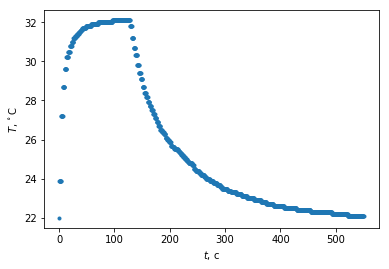

In [3]:
import matplotlib.pyplot as plt
import numpy as np

time_temperature = np.genfromtxt('00-54-17_30-12-18.tsv', delimiter='\t')

# Отсечение идентичных значений в начальный момент времени
logic_array = np.abs(time_temperature[:, 1] - time_temperature[0, 1]) > 0
time_temperature = time_temperature[np.argmax(logic_array)-1:, :]

time = time_temperature[:, 0] - time_temperature[0, 0]
temperature = time_temperature[:, 1]
plt.xlabel('$t$, c')
plt.ylabel('$T, ^\circ$C')
plt.plot(time, temperature, '.')
plt.show()

Опишем полученную зависимость при помощи закона Ньютона-Рихмана. Этот закон описывает процесс теплопередачи на границе тел через коэффициент теплоотдачи $\alpha$ [Вт/(м$^2$ K)]. В общем случае коффициент зависит от множества составляющих и определяется экспериментально.

Количество теплоты, отданное через площадку на границе раздела тел площадью $S$ за время $t$, пропорционально разности температур этих тел $\Delta T$ (если считать, что она остаётся за это время постоянной):

$$Q = \alpha t S \Delta T$$

Если температура внутри тела однородна, то уравнение охлаждения записывается в виде:

$$\dfrac{\partial T}{\partial t} = k (T_2 - T_1).$$

Здесь коэффициент $k = \dfrac{\alpha S}{C} $, где $C$ — теплоемкость тела. Из этого уравнения следует:

$$T(t) = T_2 + e^{-kt}(T_1 - T_2)$$

In [76]:
def NR(t, T1, T2, k):
     return T2 + np.exp(-k*t)*(T1 - T2)

In [77]:
# Разделим зависимость на два участка:

border_time_index = -np.argmax(temperature[::-1])
tt_raise = time_temperature[:border_time_index, :]
tt_fall  = time_temperature[border_time_index:, :]

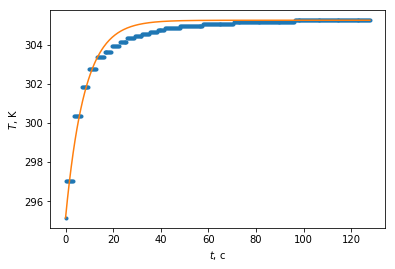

In [81]:
# Участок роста температуры

time_raise = tt_raise[:, 0] - time_temperature[0, 0]
temperature_raise = tt_raise[:, 1] + 273.15

plt.xlabel('$t$, c')
plt.ylabel('$T$, K')
plt.plot(time_raise, temperature_raise, '.')
plt.plot(time_raise, NR(time_raise, temperature_raise.min(), temperature_raise.max(), 0.125))
plt.show()

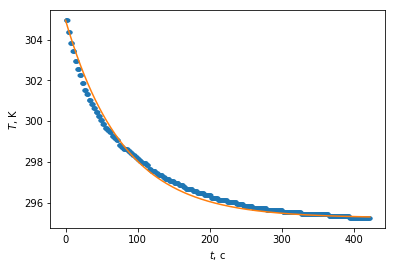

In [80]:
# Участок спада

time_fall = tt_fall[:, 0] -  tt_fall[0, 0]
temperature_fall = tt_fall[:, 1] + 273.15
plt.xlabel('$t$, c')
plt.ylabel('$T$, K')
plt.plot(time_fall, temperature_fall, '.')
plt.plot(time_fall, NR(time_fall, temperature_fall.max(), temperature_fall.min(), 0.0125))
plt.show()

Сравним $\dfrac{\alpha}{C}$:

кожа:   0.5/4180 = 1.12e-04
воздух: 0.0259/1007 = 2.57e-05

Разница в 4.35, что по порядку соотносится с ве

In [85]:
1.12e-04/2.57e-05

4.357976653696498